## Урок 2

In [5]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb

from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score, \
                            classification_report, plot_confusion_matrix, plot_precision_recall_curve, \
                            precision_recall_curve, recall_score, plot_roc_curve)

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# plt.style.use('fivethirtyeight')
# %config InlineBackend.figure_format = 'svg'
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [6]:
train = pd.read_csv(r"./assignment_2_train.csv")
test = pd.read_csv(r"./assignment_2_test.csv")

In [7]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
test.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Задание 1: отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 541.1+ MB


In [6]:
train_numeric = train.select_dtypes(include=[np.number])
train_numeric

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.50,13926,NaN,150.0,142.0,315.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,2755,404.0,150.0,102.0,325.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,4663,490.0,150.0,166.0,330.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,18132,567.0,150.0,117.0,476.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,4497,514.0,150.0,102.0,420.0,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3166995,0,3958217,39.00,1877,310.0,150.0,224.0,272.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179996,3166996,0,3958237,59.95,10075,514.0,150.0,224.0,315.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179997,3166997,0,3958241,34.00,6053,122.0,150.0,195.0,330.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179998,3166998,0,3958260,59.00,7726,555.0,150.0,226.0,272.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
X = train_numeric.drop(['isFraud'], axis=1)
y = train_numeric['isFraud']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=99)

In [54]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [55]:
model_gb1 = xgb.XGBClassifier(**params)
model_gb1.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=25
)

[0]	validation_0-auc:0.65287	validation_1-auc:0.63767
[25]	validation_0-auc:0.84078	validation_1-auc:0.83603
[50]	validation_0-auc:0.88315	validation_1-auc:0.87315
[75]	validation_0-auc:0.89311	validation_1-auc:0.88472
[100]	validation_0-auc:0.89963	validation_1-auc:0.89120
[125]	validation_0-auc:0.90399	validation_1-auc:0.89405
[150]	validation_0-auc:0.90749	validation_1-auc:0.89576
[175]	validation_0-auc:0.90763	validation_1-auc:0.89575
[194]	validation_0-auc:0.90763	validation_1-auc:0.89575


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=100,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

### Задание 2: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

In [12]:
all_train = train.copy()
all_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
cat_cols = train.select_dtypes(include=[np.object]).columns.tolist()
cat_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [14]:
all_train['ProductCD'].value_counts()

W    110340
H     22422
R     21926
C     21664
S      3648
Name: ProductCD, dtype: int64

In [15]:
hash_space = 0.1
for item_column in cat_cols:
    for itm in all_train[item_column].value_counts().index.tolist():
        all_train.loc[all_train[item_column] == itm, item_column] = (hash(itm) % hash_space)

    all_train[item_column] = all_train[item_column].astype('float')

In [16]:
all_train['ProductCD'].value_counts()

0.094975    110340
0.087314     22422
0.003198     21926
0.052051     21664
0.077632      3648
Name: ProductCD, dtype: int64

In [17]:
X2 = all_train.drop(['isFraud'], axis=1)
y2 = all_train['isFraud']

X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, y2, test_size=0.2, random_state=99)

In [18]:
model_gb2 = xgb.XGBClassifier(**params)
model_gb2.fit(
    X=X_train2,
    y=y_train2,
    eval_set=[(X_train2, y_train2), (X_valid2, y_valid2)],
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=10
)

[0]	validation_0-auc:0.65287	validation_1-auc:0.63767
[10]	validation_0-auc:0.78898	validation_1-auc:0.76630
[20]	validation_0-auc:0.82800	validation_1-auc:0.81994
[30]	validation_0-auc:0.85948	validation_1-auc:0.84774
[40]	validation_0-auc:0.87613	validation_1-auc:0.86616
[50]	validation_0-auc:0.88688	validation_1-auc:0.87471
[60]	validation_0-auc:0.89578	validation_1-auc:0.88431
[70]	validation_0-auc:0.90077	validation_1-auc:0.88941
[80]	validation_0-auc:0.90494	validation_1-auc:0.89351
[90]	validation_0-auc:0.90705	validation_1-auc:0.89546
[100]	validation_0-auc:0.91006	validation_1-auc:0.89756
[110]	validation_0-auc:0.91194	validation_1-auc:0.89924
[120]	validation_0-auc:0.91357	validation_1-auc:0.90042
[130]	validation_0-auc:0.91511	validation_1-auc:0.90163
[140]	validation_0-auc:0.91637	validation_1-auc:0.90261
[150]	validation_0-auc:0.91684	validation_1-auc:0.90283
[160]	validation_0-auc:0.91684	validation_1-auc:0.90283
[170]	validation_0-auc:0.91684	validation_1-auc:0.90283
[18

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=100,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

### Задание 3: для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [19]:
params2 = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "n_jobs": 6,
    "seed": 27
}

In [20]:
from lightgbm import LGBMClassifier
import lightgbm as lgb
model_lgbm1 = LGBMClassifier(**params2)
model_lgbm1.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=25
)

Training until validation scores don't improve for 25 rounds
[25]	training's auc: 0.86447	valid_1's auc: 0.851898
[50]	training's auc: 0.879598	valid_1's auc: 0.870263
[75]	training's auc: 0.885776	valid_1's auc: 0.877906
[100]	training's auc: 0.892919	valid_1's auc: 0.882228
[125]	training's auc: 0.898091	valid_1's auc: 0.889125
[150]	training's auc: 0.902778	valid_1's auc: 0.892661
[175]	training's auc: 0.906846	valid_1's auc: 0.895612
[200]	training's auc: 0.910409	valid_1's auc: 0.897865
[225]	training's auc: 0.913833	valid_1's auc: 0.900577
[250]	training's auc: 0.917959	valid_1's auc: 0.902784
[275]	training's auc: 0.921431	valid_1's auc: 0.905034
[300]	training's auc: 0.925384	valid_1's auc: 0.907025
[325]	training's auc: 0.929127	valid_1's auc: 0.909064
[350]	training's auc: 0.93205	valid_1's auc: 0.910517
[375]	training's auc: 0.935323	valid_1's auc: 0.912015
[400]	training's auc: 0.938013	valid_1's auc: 0.913821
[425]	training's auc: 0.94	valid_1's auc: 0.914897
[450]	trainin

LGBMClassifier(learning_rate=0.01, metric='auc', n_estimators=1000, n_jobs=6,
               objective='binary', seed=27)

In [22]:
# dtrain = lgb.Dataset(
#     data=X_train3, label=y_train3
# )
# dvalid = lgb.Dataset(
#     data=X_valid3, label=y_valid3
# )

# cv_result = lgb.cv(
#     params=params2,
#     train_set=dtrain,
#     num_boost_round=200,
#     categorical_feature="auto",
#     early_stopping_rounds=50,
#     verbose_eval=10,
#     stratified=True,
#     shuffle=True,
#     nfold=5, 
# )

### Задание 4: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 3.

In [23]:
model_lgbm2 = LGBMClassifier(**params2)
model_lgbm2.fit(
    X=X_train2,
    y=y_train2,
    eval_set=[(X_train2, y_train2), (X_valid2, y_valid2)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=25
)

Training until validation scores don't improve for 25 rounds
[25]	training's auc: 0.870206	valid_1's auc: 0.859421
[50]	training's auc: 0.882152	valid_1's auc: 0.872311
[75]	training's auc: 0.887561	valid_1's auc: 0.877912
[100]	training's auc: 0.898283	valid_1's auc: 0.886104
[125]	training's auc: 0.903532	valid_1's auc: 0.890294
[150]	training's auc: 0.90875	valid_1's auc: 0.895304
[175]	training's auc: 0.913236	valid_1's auc: 0.898689
[200]	training's auc: 0.917469	valid_1's auc: 0.902348
[225]	training's auc: 0.921762	valid_1's auc: 0.905749
[250]	training's auc: 0.92698	valid_1's auc: 0.909311
[275]	training's auc: 0.931447	valid_1's auc: 0.912974
[300]	training's auc: 0.934462	valid_1's auc: 0.915333
[325]	training's auc: 0.937662	valid_1's auc: 0.917496
[350]	training's auc: 0.940669	valid_1's auc: 0.918895
[375]	training's auc: 0.942944	valid_1's auc: 0.920111
[400]	training's auc: 0.9451	valid_1's auc: 0.921194
[425]	training's auc: 0.947292	valid_1's auc: 0.923338
[450]	train

LGBMClassifier(learning_rate=0.01, metric='auc', n_estimators=1000, n_jobs=6,
               objective='binary', seed=27)

### Задание 5: обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 4.


In [24]:
# Преобразуем сначала object в category, потому что LGBM работает с категорями
for feature in cat_cols:
    train[feature] = pd.Series(train[feature], dtype="category")

In [25]:
# Подадим все признаки без обработки
X3 = train.drop(['isFraud'], axis=1)
y3 = train['isFraud']

X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X3, y3, test_size=0.2, random_state=99)

In [26]:
model_lgbm3 = LGBMClassifier(**params2)
model_lgbm3.fit(
    categorical_feature=cat_cols,
    X=X_train3,
    y=y_train3,
    eval_set=[(X_train3, y_train3), (X_valid3, y_valid3)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=25
)

Training until validation scores don't improve for 25 rounds
[25]	training's auc: 0.864806	valid_1's auc: 0.85272
[50]	training's auc: 0.883851	valid_1's auc: 0.872015
[75]	training's auc: 0.895396	valid_1's auc: 0.882771
[100]	training's auc: 0.901802	valid_1's auc: 0.888125
[125]	training's auc: 0.905786	valid_1's auc: 0.890855
[150]	training's auc: 0.91104	valid_1's auc: 0.895554
[175]	training's auc: 0.916053	valid_1's auc: 0.899284
[200]	training's auc: 0.919833	valid_1's auc: 0.902524
[225]	training's auc: 0.923323	valid_1's auc: 0.904849
[250]	training's auc: 0.927672	valid_1's auc: 0.908163
[275]	training's auc: 0.932963	valid_1's auc: 0.91144
[300]	training's auc: 0.936375	valid_1's auc: 0.913816
[325]	training's auc: 0.939758	valid_1's auc: 0.91598
[350]	training's auc: 0.942099	valid_1's auc: 0.917979
[375]	training's auc: 0.944271	valid_1's auc: 0.919671
[400]	training's auc: 0.946536	valid_1's auc: 0.921214
[425]	training's auc: 0.949108	valid_1's auc: 0.922437
[450]	train

LGBMClassifier(learning_rate=0.01, metric='auc', n_estimators=1000, n_jobs=6,
               objective='binary', seed=27)

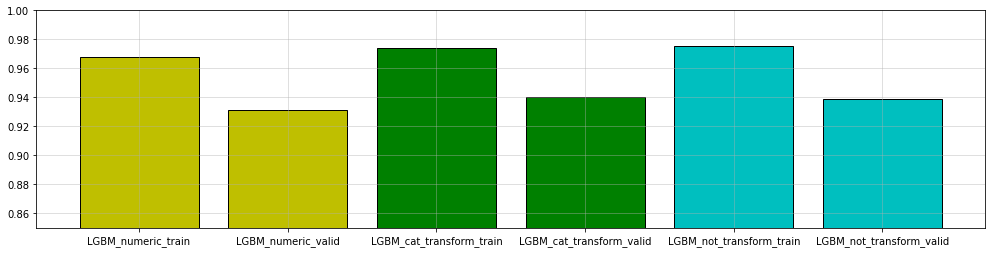

In [27]:
plt.figure(figsize=(17,4))
barlist = plt.bar(np.arange(1, 7),
        [model_lgbm1.best_score_.get('training').get('auc'), model_lgbm1.best_score_.get('valid_1').get('auc'),
        model_lgbm2.best_score_.get('training').get('auc'), model_lgbm2.best_score_.get('valid_1').get('auc'),
        model_lgbm3.best_score_.get('training').get('auc'), model_lgbm3.best_score_.get('valid_1').get('auc')],
        edgecolor='black', linewidth=1,
                  tick_label=['LGBM_numeric_train','LGBM_numeric_valid',
                              'LGBM_cat_transform_train','LGBM_cat_transform_valid',
                              'LGBM_not_transform_train', 'LGBM_not_transform_valid'], color=['y','y','g','g','c','c'])
# barlist[0].set_color('yellow')
plt.ylim(0.85, 1)
plt.grid(alpha=0.5)
plt.show()

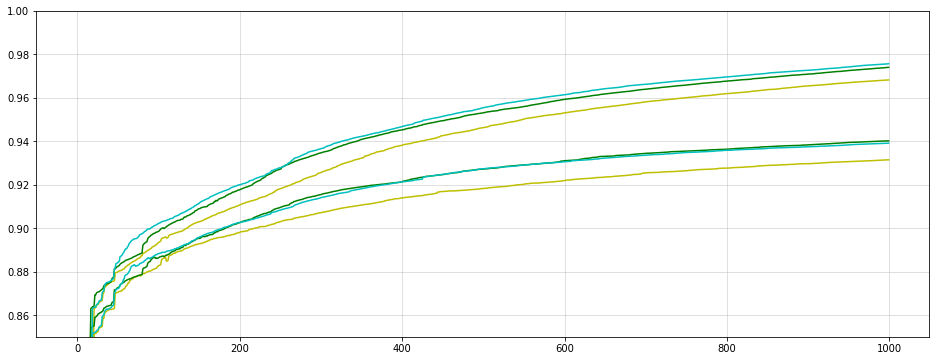

In [28]:
plt.figure(figsize=(16, 6))
plt.plot(np.arange(len(model_lgbm1.evals_result_.get('training').get('auc'))),
        model_lgbm1.evals_result_.get('training').get('auc'), color='y')
plt.plot(np.arange(len(model_lgbm1.evals_result_.get('training').get('auc'))),
         model_lgbm1.evals_result_.get('valid_1').get('auc'), color='y')

plt.plot(np.arange(len(model_lgbm1.evals_result_.get('training').get('auc'))),
        model_lgbm2.evals_result_.get('training').get('auc'), color='g')
plt.plot(np.arange(len(model_lgbm1.evals_result_.get('training').get('auc'))),
         model_lgbm2.evals_result_.get('valid_1').get('auc'), color='g')

plt.plot(np.arange(len(model_lgbm1.evals_result_.get('training').get('auc'))),
        model_lgbm3.evals_result_.get('training').get('auc'), color='c')
plt.plot(np.arange(len(model_lgbm1.evals_result_.get('training').get('auc'))),
         model_lgbm3.evals_result_.get('valid_1').get('auc'), color='c')
plt.ylim(0.85, 1)
plt.grid(alpha=0.5)
plt.show()

Выводы: использование максимального количества признаков обеспечивает лучший результат по сравнению с использованием только вещественных признаков. Прирост качества между ручной обработкой и встроенным методом в LightGBM незначительный, однако встроенный метод экономит время, которое необходимо уделить обработке категориальных признаков.

### Задание 6: для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [29]:
import catboost as cb
cb_params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 25,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [30]:
model_cb1 = cb.CatBoostClassifier(**cb_params)
model_cb1.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)])

0:	test: 0.6498514	test1: 0.6389082	best: 0.6389082 (0)	total: 155ms	remaining: 2m 34s
25:	test: 0.8342303	test1: 0.8229762	best: 0.8231485 (24)	total: 2.25s	remaining: 1m 24s
50:	test: 0.8549277	test1: 0.8429631	best: 0.8434950 (48)	total: 4.42s	remaining: 1m 22s
75:	test: 0.8593181	test1: 0.8485207	best: 0.8485856 (74)	total: 6.48s	remaining: 1m 18s
100:	test: 0.8650631	test1: 0.8562184	best: 0.8562184 (100)	total: 8.64s	remaining: 1m 16s
125:	test: 0.8699124	test1: 0.8626887	best: 0.8626887 (125)	total: 10.8s	remaining: 1m 14s
150:	test: 0.8739689	test1: 0.8669919	best: 0.8669919 (150)	total: 13s	remaining: 1m 13s
175:	test: 0.8774260	test1: 0.8694014	best: 0.8694014 (175)	total: 15.3s	remaining: 1m 11s
200:	test: 0.8805125	test1: 0.8726719	best: 0.8726719 (200)	total: 17.4s	remaining: 1m 9s
225:	test: 0.8828850	test1: 0.8750647	best: 0.8750647 (225)	total: 19.7s	remaining: 1m 7s
250:	test: 0.8843550	test1: 0.8766637	best: 0.8766637 (250)	total: 21.8s	remaining: 1m 5s
275:	test: 0.8

### Задание 7: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 6.

In [31]:
model_cb2 = cb.CatBoostClassifier(**cb_params)
model_cb2.fit(X_train2, y_train2, eval_set=[(X_train2, y_train2), (X_valid2, y_valid2)])

0:	test: 0.6680477	test1: 0.6574057	best: 0.6574057 (0)	total: 98.4ms	remaining: 1m 38s
25:	test: 0.8237252	test1: 0.8177426	best: 0.8181713 (24)	total: 2.21s	remaining: 1m 22s
50:	test: 0.8555098	test1: 0.8430806	best: 0.8430806 (50)	total: 4.34s	remaining: 1m 20s
75:	test: 0.8612728	test1: 0.8496029	best: 0.8496128 (74)	total: 6.44s	remaining: 1m 18s
100:	test: 0.8686801	test1: 0.8584552	best: 0.8584552 (100)	total: 8.56s	remaining: 1m 16s
125:	test: 0.8754945	test1: 0.8662506	best: 0.8662506 (125)	total: 10.8s	remaining: 1m 15s
150:	test: 0.8794646	test1: 0.8709400	best: 0.8709400 (150)	total: 13.1s	remaining: 1m 13s
175:	test: 0.8846966	test1: 0.8759777	best: 0.8759777 (175)	total: 15.5s	remaining: 1m 12s
200:	test: 0.8877919	test1: 0.8789548	best: 0.8789548 (200)	total: 17.8s	remaining: 1m 10s
225:	test: 0.8899082	test1: 0.8806723	best: 0.8806826 (224)	total: 20s	remaining: 1m 8s
250:	test: 0.8923374	test1: 0.8830600	best: 0.8830600 (250)	total: 22.3s	remaining: 1m 6s
275:	test: 0

### Задание 8: обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 7.

In [84]:
cat_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [85]:
for ii in train[cat_cols]:
    train[ii] = train[ii].astype(str)

In [86]:
cat_features_idx = np.where(train.drop('isFraud', axis=1).dtypes == "object")[0].tolist()
cat_features_idx

[3, 7, 9, 14, 15, 45, 46, 47, 48, 49, 50, 51, 52, 53]

In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 541.1+ MB


In [88]:
for ii in train.drop('isFraud', axis=1).select_dtypes(include=['float', 'int']).columns.tolist():
    train[ii] = train[ii].fillna(-1)

In [89]:
train.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [90]:
X4 = train.drop(['isFraud'], axis=1)
y4 = train['isFraud']
X_train4, X_valid4, y_train4, y_valid4 = train_test_split(X4, y4, test_size=0.2, random_state=99)

In [91]:
model_cb3 = cb.CatBoostClassifier(**cb_params)
model_cb3.fit(X_train4, y_train4, eval_set=[(X_train4, y_train4), (X_valid4, y_valid4)], cat_features=cat_features_idx)

0:	test: 0.7395602	test1: 0.7368920	best: 0.7368920 (0)	total: 509ms	remaining: 8m 28s
25:	test: 0.8341832	test1: 0.8243008	best: 0.8243008 (25)	total: 11.1s	remaining: 6m 57s
50:	test: 0.8522459	test1: 0.8412291	best: 0.8414035 (45)	total: 21.8s	remaining: 6m 46s
75:	test: 0.8569317	test1: 0.8460409	best: 0.8460409 (75)	total: 32.4s	remaining: 6m 33s
100:	test: 0.8681592	test1: 0.8588925	best: 0.8588925 (100)	total: 43.3s	remaining: 6m 25s
125:	test: 0.8728722	test1: 0.8644461	best: 0.8644461 (125)	total: 55s	remaining: 6m 21s
150:	test: 0.8774647	test1: 0.8695616	best: 0.8695616 (150)	total: 1m 5s	remaining: 6m 10s
175:	test: 0.8825669	test1: 0.8749349	best: 0.8749349 (175)	total: 1m 16s	remaining: 5m 58s
200:	test: 0.8858974	test1: 0.8786968	best: 0.8786968 (200)	total: 1m 27s	remaining: 5m 48s
225:	test: 0.8889139	test1: 0.8812943	best: 0.8812943 (225)	total: 1m 38s	remaining: 5m 37s
250:	test: 0.8915040	test1: 0.8840819	best: 0.8840819 (250)	total: 1m 49s	remaining: 5m 26s
275:	te

### Задание 9: построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

In [92]:
test.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# import catboost.utils as cbu

# def calculate_score_on_dataset_and_show_graph(X, y, model):
#     import sklearn.metrics
#     import matplotlib.pylab as pl
#     pl.style.use('ggplot')
    
#     dataset = cb.Pool(X, y, cat_features=np.where(X.dtypes != np.float)[0])
#     fpr, tpr, _ = cbu.get_roc_curve(model, dataset, plot=True)
#     auc = sklearn.metrics.auc(fpr, tpr)
#     return auc
# calculate_score_on_dataset_and_show_graph(X_test, y_test, model_cb3)

In [93]:
catboost_test = test.copy()

for ii in catboost_test[cat_cols]:
    catboost_test[ii] = catboost_test[ii].astype(str)
    
for ii in catboost_test.drop('isFraud', axis=1).select_dtypes(include=['float', 'int']).columns.tolist():
    catboost_test[ii] = catboost_test[ii].fillna(-1)
    
catboost_test.isna().sum().values

In [96]:
cat_features_idxx = np.where(catboost_test.drop('isFraud', axis=1).dtypes == "object")[0].tolist()
cat_features_idxx

[3, 7, 9, 14, 15, 45, 46, 47, 48, 49, 50, 51, 52, 53]

In [110]:
X_test_catb = catboost_test.drop('isFraud', axis=1)
y_test_catb = catboost_test['isFraud']

In [103]:
model_cb3_pred_proba = model_cb3.predict_proba(X_test_catb)

In [119]:
def get_roc_auc(y_true, model_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, model_pred_proba[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

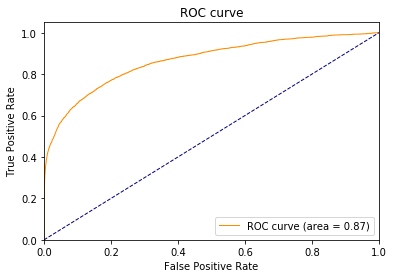

In [120]:
get_roc_auc(y_test_catb, model_cb3_pred_proba)

In [112]:
roc_auc_score(y_test_catb, model_cb3_pred_proba[:,1])

0.8658277486830472

###### ------------------------------------------------------------------------------------------------

In [105]:
lightgbm_test = test.copy()

# Преобразуем сначала object в category, потому что LGBM работает с категорями
for feature in cat_cols:
    lightgbm_test[feature] = pd.Series(lightgbm_test[feature], dtype="category")
    
X_test_lgbm = lightgbm_test.drop('isFraud', axis=1)
y_test_lgbm = lightgbm_test['isFraud']

In [106]:
model_lgbm3_pred_proba = model_lgbm3.predict_proba(X_test_lgbm)

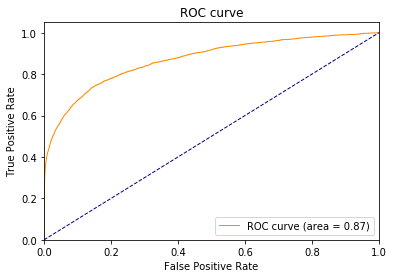

In [121]:
get_roc_auc(y_test_lgbm, model_lgbm3_pred_proba)

In [113]:
roc_auc_score(y_test_lgbm, model_lgbm3_pred_proba[:,1])

0.8695011645124876

###### ------------------------------------------------------------------------------------------------

In [114]:
gb_test = test.copy()

hash_space = 0.1
for item_column in cat_cols:
    for itm in gb_test[item_column].value_counts().index.tolist():
        gb_test.loc[gb_test[item_column] == itm, item_column] = (hash(itm) % hash_space)

    gb_test[item_column] = gb_test[item_column].astype('float')

In [115]:
X_test_gb = gb_test.drop('isFraud', axis=1)
y_test_gb = gb_test['isFraud']

In [116]:
model_gb2_pred_proba = model_gb2.predict_proba(X_test_gb)

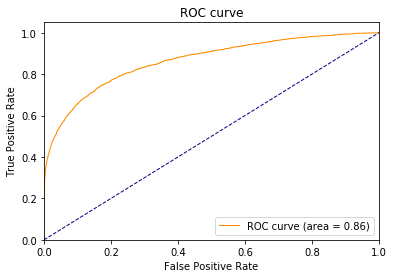

In [122]:
get_roc_auc(y_test_gb, model_gb2_pred_proba)

In [118]:
roc_auc_score(y_test_gb, model_gb2_pred_proba[:,1])

0.8640699260270834

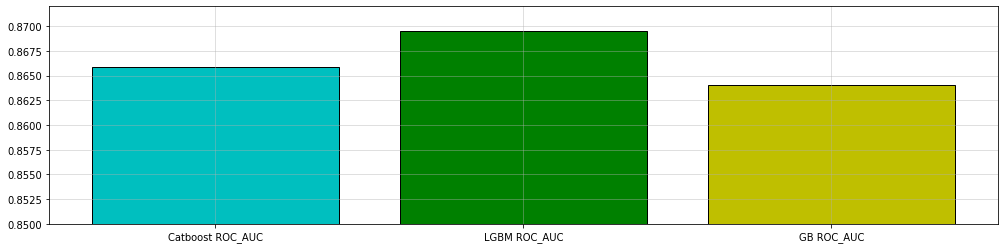

In [134]:
plt.figure(figsize=(17,4))
barlist = plt.bar(np.arange(1, 4),
        [roc_auc_score(y_test_catb, model_cb3_pred_proba[:,1]),
        roc_auc_score(y_test_lgbm, model_lgbm3_pred_proba[:,1]),
        roc_auc_score(y_test_gb, model_gb2_pred_proba[:,1])],
        edgecolor='black', linewidth=1,
                  tick_label=['Catboost ROC_AUC','LGBM ROC_AUC',
                              'GB ROC_AUC'], color=['c','g','y'])
# barlist[0].set_color('yellow')
plt.ylim(0.85, 0.872)
plt.grid(alpha=0.5)
plt.show()

Выводы: Все алгоритмы хорошо обучились на тестовой выборке, результаты моделей примерно одинаковы.

### Дополнительные задания

### Задание 1: Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.


In [458]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [459]:
test.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


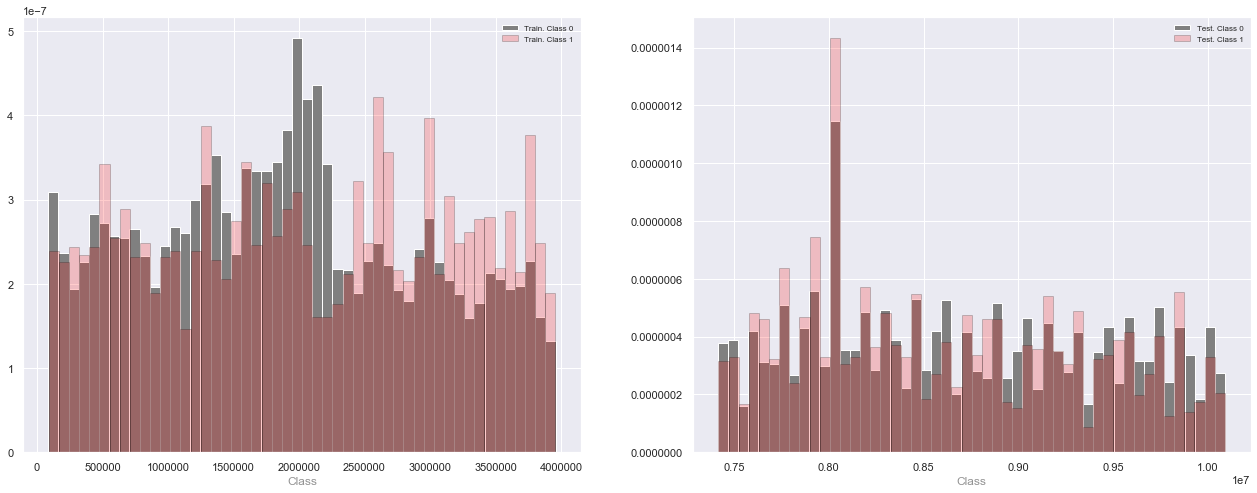

In [453]:
plt.figure(figsize=(22, 8))
plt.subplot(121)
v_zero = train.loc[train['isFraud'] == 0, 'TransactionDT']
v_one = train.loc[train['isFraud'] == 1, 'TransactionDT']
plt.hist(v_zero, bins = 50, label='Train. Class 0', density=True, edgecolor='white', color='grey')
plt.hist(v_one, bins = 50, label='Train. Class 1', alpha=0.2, density=True, edgecolor='black', color='red')
plt.xlabel('Class', alpha=0.5)
plt.legend(fontsize=8, frameon=False)

plt.subplot(122)
v2_zero = test.loc[train['isFraud'] == 0, 'TransactionDT']
v2_one = test.loc[train['isFraud'] == 1, 'TransactionDT']
plt.hist(v2_zero, bins = 50, label='Test. Class 0', density=True, edgecolor='white', color='grey')
plt.hist(v2_one, bins = 50, label='Test. Class 1', alpha=0.2, density=True, edgecolor='black', color='red')
plt.xlabel('Class', alpha=0.5)
plt.legend(fontsize=8, frameon=False)

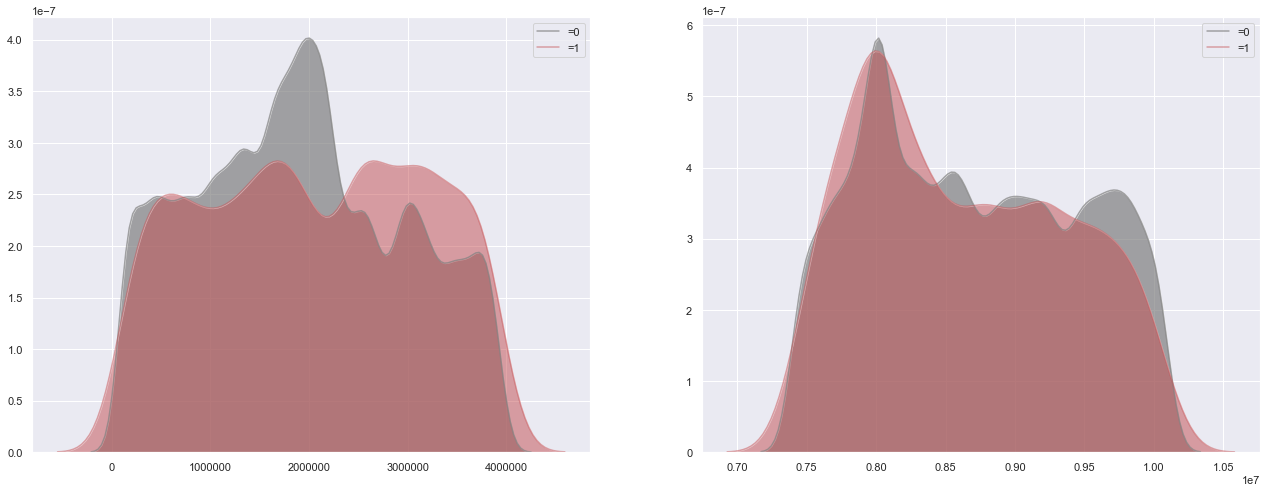

In [457]:
plt.figure(figsize=(22, 8))
plt.subplot(121)
sns.kdeplot(v_zero, shade=True, color="grey", label="=0", alpha=.7)
sns.kdeplot(v_one, shade=True, color="r", label="=1", alpha=.5)
plt.legend()

plt.subplot(122)
sns.kdeplot(v2_zero, shade=True, color="grey", label="=0", alpha=.7)
sns.kdeplot(v2_one, shade=True, color="r", label="=1", alpha=.5)
plt.legend()

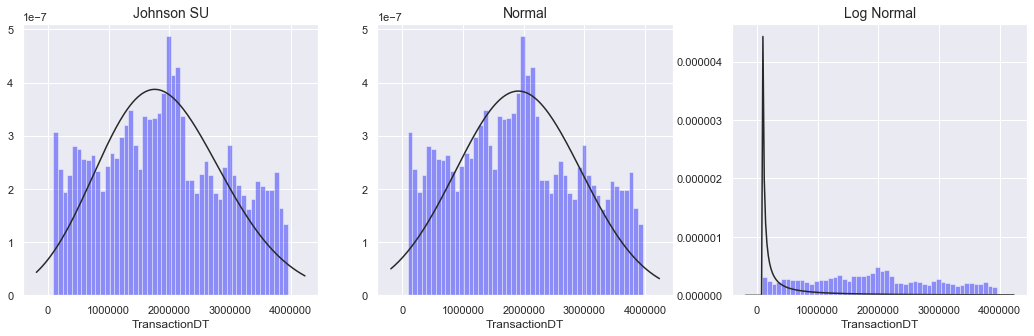

In [493]:
target = train["TransactionDT"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].set_title("Johnson SU", fontsize=14)
sns.distplot(target, kde=False, color="grey", fit=st.johnsonsu, ax=axes[0])

axes[1].set_title("Normal", fontsize=14)
sns.distplot(target, kde=False, color="grey", fit=st.norm, ax=axes[1])

axes[2].set_title("Log Normal", fontsize=14)
sns.distplot(target, kde=False, color="grey", fit=st.lognorm, ax=axes[2])

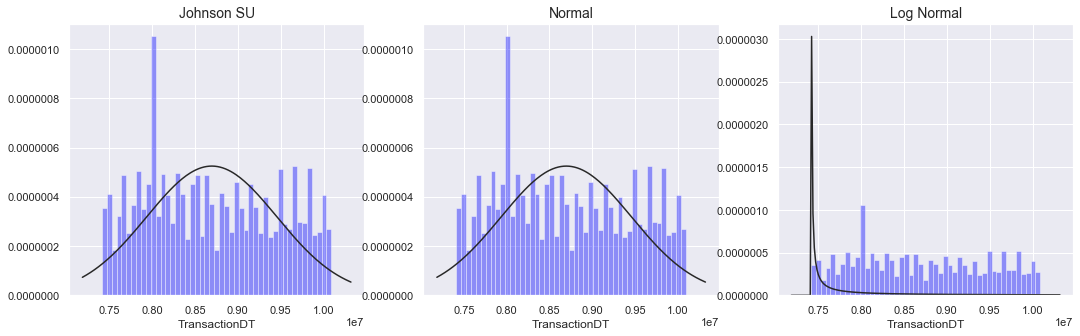

In [494]:
target = test["TransactionDT"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].set_title("Johnson SU", fontsize=14)
sns.distplot(target, kde=False, color="grey", fit=st.johnsonsu, ax=axes[0])

axes[1].set_title("Normal", fontsize=14)
sns.distplot(target, kde=False, color="grey", fit=st.norm, ax=axes[1])

axes[2].set_title("Log Normal", fontsize=14)
sns.distplot(target, kde=False, color="grey", fit=st.lognorm, ax=axes[2])

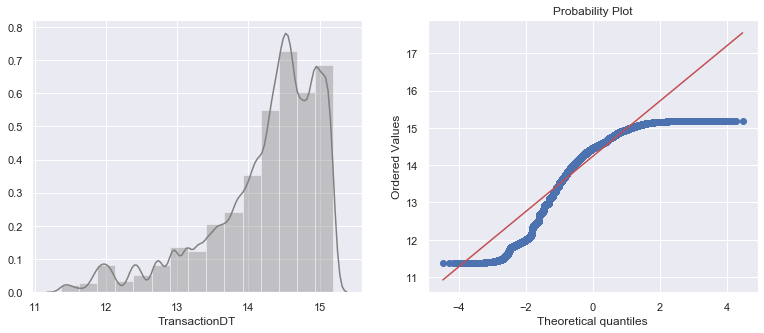

In [495]:
target = np.log(train["TransactionDT"])
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(target, bins=15, color="grey")
plt.subplot(122)
probplot(target, plot=plt)
plt.show();

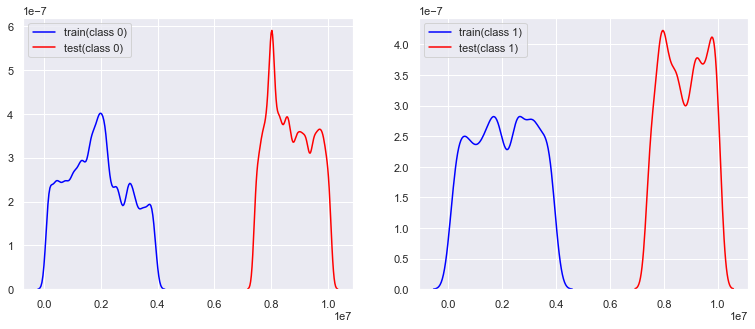

In [513]:
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.kdeplot(train.loc[train['isFraud'] == 0, "TransactionDT"], color="blue", label="train(class 0)")
sns.kdeplot(test.loc[test['isFraud'] == 0, "TransactionDT"], color="red", label="test(class 0)")
plt.subplot(122)
sns.kdeplot(train.loc[train['isFraud'] == 1, "TransactionDT"], color="blue", label="train(class 1)")
sns.kdeplot(test.loc[test['isFraud'] == 1, "TransactionDT"], color="red", label="test(class 1)")

In [505]:
train.TransactionDT.describe()

count    1.800000e+05
mean     1.909818e+06
std      1.039029e+06
min      8.640000e+04
25%      1.091681e+06
50%      1.884075e+06
75%      2.693196e+06
max      3.958317e+06
Name: TransactionDT, dtype: float64

In [506]:
test.TransactionDT.describe()

count    1.000010e+05
mean     8.696663e+06
std      7.603909e+05
min      7.415038e+06
25%      8.023328e+06
50%      8.630067e+06
75%      9.346592e+06
max      1.009155e+07
Name: TransactionDT, dtype: float64

Выводы: значения TransactionDT распределены ненормально на трейне и на тесте и имеют разное распределение статистики, в том числе в разрезе целевого класса. Предположительно необходимо использовать валидацию hold-out и разбить трейн выборку не менее чем на 3 части(train, test, valid), а также провести кросс-валидацию на 5 и более фолдах.